<a href="https://colab.research.google.com/github/Sejong-Kaggle-Challengers/jeongmin/blob/main/%EC%8B%A0%EC%9A%A9%EC%B9%B4%EB%93%9C_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%8B%9C%EA%B0%81%ED%99%94(3%EB%93%B1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip data04.zip

Archive:  data04.zip
  inflating: submission.csv          
  inflating: test.csv.zip            
  inflating: train.csv.zip           


In [2]:
!unzip train.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
   creating: __MACOSX/
  inflating: __MACOSX/._train.csv    
Archive:  test.csv.zip
  inflating: test.csv                
  inflating: __MACOSX/._test.csv     


#1. Column 요약
- store_id : 각 파일에서의 상점 고유 번호.
- date : 거래 일자
- time : 거래 시간
- card_id : 카드 번호의 hash 값
- amount : 매출액, 0보다 작은 음수는 거래 취소(환불), 단위 krw 아님, 할부개월수만큼 amount들어옴
- installments : 할부개월수. 일시불은 빈 문자열
- days_of_week : 요일, 월요일이 0, 일요일은 6
- holyday : 1이면 공휴일, 0이면 공휴일 아님

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False #그래프에서 마이너스 기호가 깨지지 않고 표시되도록
from matplotlib import rc
import seaborn as sns
import numpy as np
from collections import Counter

#2. Data Load & Check

In [4]:
train = pd.read_csv("train.csv")
train.head()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
0,0,2016-12-14,18:05:31,d297bba73f,5,NaN,2,0
1,0,2016-12-14,18:05:54,d297bba73f,-5,NaN,2,0
2,0,2016-12-19,12:42:31,0880849c05,144,NaN,0,0
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,NaN,0,0
4,0,2016-12-19,13:31:08,7ad237eed0,24,NaN,0,0


In [5]:
print(train.shape)

(3362796, 8)


In [6]:
train.describe() #데이터 요약 (date/time/card_id는 정수형이 아니라서 제외된 것 같다.)

,store_id,amount,installments,days_of_week,holyday
count,3.362796e+06,3.362796e+06,16860.000000,3.362796e+06,3.362796e+06
mean,8.323770e+02,1.459623e+02,3.459490,3.066320e+00,4.431283e-02
std,5.468544e+02,6.017306e+02,2.382382,1.976153e+00,2.057892e-01
min,0.000000e+00,-2.500000e+05,2.000000,0.000000e+00,0.000000e+00
25%,3.350000e+02,3.200000e+01,3.000000,1.000000e+00,0.000000e+00
50%,8.220000e+02,7.500000e+01,3.000000,3.000000e+00,0.000000e+00
75%,1.342000e+03,1.500000e+02,3.000000,5.000000e+00,0.000000e+00
max,1.799000e+03,2.500000e+05,36.000000,6.000000e+00,1.000000e+00


#3. Preprocess
3.1 Remove Outliers
outlier가 있을 수 있다고 판단되는 column을 선택
--> amount --> outlier 제거

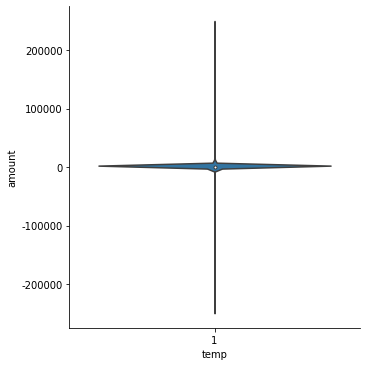

In [7]:
#vilolinplot을 이용해 분포 범위 확인
#: amount의 분포 범위는 넓은데 분포는 한쪽으로 편중되어 확인이 어려움
train["temp"] = 1
sns.catplot(data=train, x = "temp", y = 'amount', kind = 'violin')

In [8]:
#따라서 numpy의 percentile을 이용해 데이터가 차지하는 비율을 확인
#percentile -> 백분위수
percentage_99 = np.percentile(train["amount"], 99)
print(percentage_99)
percentage_98 = np.percentile(train["amount"], 98)
print(percentage_98)

1335.0
800.0


amount의 최대값은 250000, 최소값은 -250000<br>
데이터의 약 99%가 차지하는 위치의 amount값 1335<br>데이터의 약 98%가 차지하는 위치의 amount값 800<br>대부분의 데이터가 1000 이하에 위치하고 있음을 의미한다. <br>따라서 1000이상, -1000이하의 값을 outlier로 간주한다.

In [9]:
#train = train.loc[(train["amount"]&gt;= -1000)&(train["amount"]&lt;= 1000)] 오류뜸
#a gt b --> a > b
#a lt b --> a < b

#outlier 제거
train = train.loc[(train["amount"] > -1000)&(train["amount"]< 1000)]

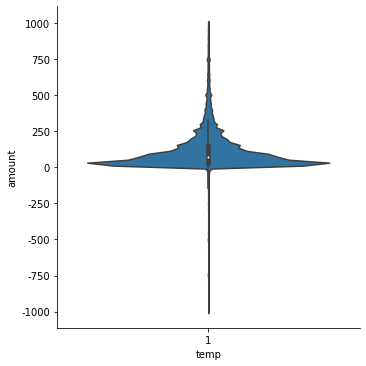

In [10]:
#outlier를 제거하기 전보다 더 고르게 분포한다.
sns.catplot(data=train, x="temp", y="amount", kind="violin")

3.2 null data 채우기
- installments : 할부개월수
<br>총 데이터 3362796 중  3298873가 null값 

In [11]:
train.isnull().sum() 

store_id              0
date                  0
time                  0
card_id               0
amount                0
installments    3298873
days_of_week          0
holyday               0
temp                  0
dtype: int64

In [12]:
#null값은 일시불을 의미하기 때문에 분할 값을 1로 채웠다.
train.loc[train["installments"].isnull(), "installments"] = 1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [13]:
train.isnull().sum()

store_id        0
date            0
time            0
card_id         0
amount          0
installments    0
days_of_week    0
holyday         0
temp            0
dtype: int64

3.3 Make Total Column
- amount는 총액이 할부 단위로 계산된 금액
- 총액을 나타내는 total이라는 column을 생성한다.
<br> total = amount * installments

In [14]:
train["total"] = train["amount"] * train["installments"]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#4. Data Analysis & Feature Engineering

In [15]:
#아까 바이올린 plot을 위해 만들었기 때문에 삭제
del train["temp"]

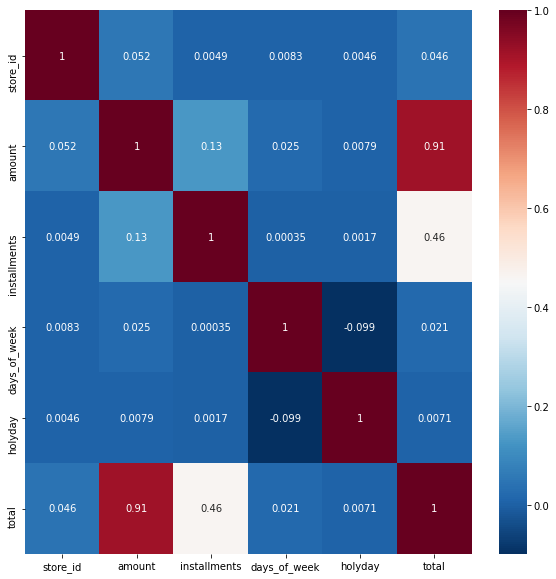

In [18]:
#상관계수
plt.figure(figsize = (10, 10)) #그래프? 의 크기가 바뀐다
sns.heatmap(train[train.columns].corr(), cmap = "RdBu_r", annot = True)

4.1 store_id

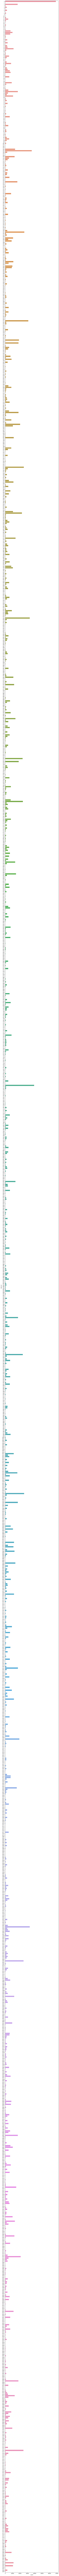

In [19]:
#countplot
figure, ax = plt.subplots()
figure.set_size_inches(10, 500)
sns.countplot(data=train, y = "store_id")

'''
store_id의 경향성 파악을 위함 --> 따로 확인된 것 없음
가게마다 거래기록 count 편차가 심하게 난다.
'''

In [21]:
#store_id간 거래기록을 count
count_list = []
for i in range(1799):
  train_temp = train.loc[train["store_id"] == i]
  values = {"count" : train_temp.shape[0]}
  count_list.append(values)

In [25]:
#DataFrame.from_dict() --> 딕셔너리를 입력으로 가진다.
#orient라는 입력 변수 columns(키를 열의 레이블/default)/index(키를 행의 레이블)
count_list = pd.DataFrame.from_dict(count_list)
count_list = count_list.sort_values(by = "count", ascending = False) # ascending = False : 내림차순 정렬
count_list.index.name = "store_id"

In [27]:
#store_id 별 거래 기록 count 상위 10개 (환불기록 포함)
# 유동인구가 많은 곳에 위치해 접근성이 높거나 충성도 높은 고객을 보유하고 있음을 예측할 수 있다.
count_list.head(10)

,count
store_id,
0,68714
753,39215
105,35999
1342,33325
428,33281
221,31404
161,25935
1038,25693
323,25219


In [28]:
#store_id 별 거래 기록 count 하위 10개 (환불기록 포함)
count_list.tail(10)

#카드 거래 기록 기준 하위 10개 리스트에는 2016-08-01부터 2018-07-31까지 카드 거래 기록이 0

,count
store_id,
860,0
1681,0
901,0
994,0
1657,0
1655,0
1063,0
1067,0
1649,0


In [29]:
#카드 거래 기록이 0인 가게의 수를 확인 : 61개 ...?
count_list_0 = count_list.loc[count_list["count"] == 0]
count_list_0.shape[0]

61